In [1]:
import torch

from PIL import Image
from matplotlib import pyplot as plt

import os
import numpy as np
from tqdm import trange, tqdm

import torch.optim as optim
from torch.autograd import Variable
import scipy.misc
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

import random
import time
import pickle
import pandas as pd
import math
import numbers

#import torchfcn

import ttorchfcn as torchfcn

import subprocess


In [2]:
def make_cv_folds(img_root, gt_root, num_folds, random_state):
    samples = []
    folds = [list() for i in range(num_folds)]
    lengths = [0]*num_folds
    img_root = os.path.expanduser(img_root)
    gt_root = os.path.expanduser(gt_root)
    for f in sorted(os.listdir(img_root)):
        if not os.path.isfile(os.path.join(img_root, f)) or not os.path.isfile(os.path.join(gt_root, f.rsplit(".", 1)[0] + ".png")):
            print(f, img_root)
            raise Exception("GT fehlt")
        samples.append((os.path.join(img_root, f), os.path.join(gt_root, f.rsplit(".", 1)[0] + ".png")))

    np.random.seed(random_state)
    np.random.shuffle(samples)
    np.random.seed()

    for s in samples:
        idx = np.argmin(lengths)
        folds[idx].append(s)
        lengths[idx] += 1
    return folds

def load_sample(img_path, gt_path):
    #img = Image.open(img_path)
    with open(img_path, "rb") as f_in:
        img = pickle.load(f_in)  
        img = img[:,:,:]
        
    gt = Image.open(gt_path)
    gt = np.array(gt)[:,:,2]
    
    #binary format
    gt[gt == 0] = 2
    gt[gt == 255] = 1

    #hisdb format
    gt[gt == 1] = 1
    gt[(gt%8) == 0] = 1
    gt[(gt%4) == 0] = 1
    gt[(gt%2) == 0] = 0
    gt = Image.fromarray(gt)
    return img, gt


def normalize(dataloader, dataset):        
    prediction_mean = []
    prediction_stdDev = []
    gt_mean = []
    gt_stdDev = []
        
    for i, data in enumerate(dataloader, 0):
        # shape (batch_size, 4, height, width)        
        numpy_image = data[0].numpy()
        batch_mean = np.mean(numpy_image, axis=(0,2,3))            
        batch_std1 = np.std(numpy_image,axis=(0,2,3), ddof=1)       
        prediction_mean.append(batch_mean)            
        prediction_stdDev.append(batch_std1)                


    prediction_mean = np.array(prediction_mean).mean(axis=0)
    prediction_stdDev = np.array(prediction_stdDev).mean(axis=0)  
    
    
    for i, data in enumerate(dataloader, 0):   
        # shape (1, height, width)
        numpy_image = data[1].numpy()
        batch_mean = np.mean(numpy_image, axis=(1,2))            
        batch_std1 = np.std(numpy_image,axis=(1,2), ddof=1)   
        gt_mean.append(batch_mean)            
        gt_stdDev.append(batch_std1)

    gt_mean = np.array(gt_mean).mean(axis=0)
    gt_stdDev = np.array(gt_stdDev).mean(axis=0)  
    
    return prediction_mean, prediction_stdDev, gt_mean, gt_stdDev
        


class Annotations(Dataset):
    class_names = np.array(['other', 'annotation'])
    
    def __init__(self, img_root, gt_root, loader=load_sample, num_folds=5, preprocess=None, random_state=None):
        self.folds = make_cv_folds(img_root, gt_root, num_folds=num_folds, random_state=random_state)
        self.img_root = img_root
        self.num_folds = num_folds
        self.preprocess = preprocess
        self.loader = loader
        self.is_training = True
        self.load_split(num=0)

    def train(self, val):
        if val:
            self.is_training = True
            self.samples = self.train_samples
        else:
            self.is_training = False
            self.samples = self.test_samples
    
    def load_split(self, num=0):
        if len(self.folds) == 1:
            self.train_samples = self.folds[0]
            self.test_samples = self.folds[0]
        else:
            num = num%len(self.folds)
            train_folds = list(range(0,num)) + list(range(num+1, len(self.folds)))
            test_fold = num
            self.train_samples = []
            for i in train_folds:
                self.train_samples.extend(self.folds[i])
            self.test_samples = self.folds[num]
        if self.is_training:
            self.samples = self.train_samples
        else:
            self.samples = self.test_samples
            
    def untransform(self, img, gt):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img = img.astype(np.uint8)
        img = img[..., [0,1,2,3]]     
        #img = img[:, :, ::-1]
        gt = gt.numpy()
        return img, gt

        
    def __getitem__(self, index):
        img_path, gt_path = self.samples[index]
        img, gt = self.loader(img_path, gt_path)                
        images = []
        new_image = []    
                        
        img1 = np.copy(img[:,:,:3])
        img2 = np.copy(img[:,:,3])        
#         plt.imshow(img1)
        #plt.show()                
        img1  = Image.fromarray((img1).astype('uint8'), 'RGB')        
       # plt.imshow(img1)
       # plt.show()
        img2 = Image.fromarray(img2.astype('uint8'), mode ='L')
       # plt.imshow(img2)
       # plt.show()
       
        images = [img1,img2]
        if self.preprocess is not None:            
            state = time.time()
            for item in images:  
                img = self.preprocess(item, random_state=state)
                img = np.array(img)             
                if(len(img.shape)==2):                    
                    img.shape = (1024, 1024, 1)                   
                new_image.append(img)      
            
            img = np.concatenate(new_image, axis=2)                      
            
            gt = self.preprocess(gt, random_state=state)            
               
        if(apply_transform == 1):
            if('train' in img_path):                                
                img = (img - self.trainingMean)/self.trainingStd
            
            elif('test' in img_path):                               
                img = (img - self.trainingMean)/self.trainingStd                
       
        # change
        img = img[..., [2,1,0,3]]        
        #img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).float()
        gt = np.array(gt, dtype=np.int32)
        gt = torch.from_numpy(gt).long()
        return img, gt

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Number of training samples: {}\n'.format(len(self.train_samples))
        fmt_str += '    Number of testing samples: {}\n'.format(len(self.test_samples))
        return fmt_str

In [3]:
class CenterCrop(object):
    """Crops the given PIL Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, random_state=None):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        return transforms.functional.center_crop(img, self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class RandomResizedCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.NEAREST):
        self.size = (size, size)
        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio, random_state=None):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
        
        
        random.seed(random_state)
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(*scale) * area
            aspect_ratio = random.uniform(*ratio)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback
        w = min(img.size[0], img.size[1])
        i = (img.size[1] - w) // 2
        j = (img.size[0] - w) // 2
        return i, j, w, w

    def __call__(self, img, random_state=None):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio, random_state=random_state)
        return transforms.functional.resized_crop(img, i, j, h, w, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(round(self.scale, 4))
        format_string += ', ratio={0}'.format(round(self.ratio, 4))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string

    
class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(img, output_size, random_state=None):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        random.seed(random_state)
        
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img, random_state=None):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        if self.padding > 0:
            img = F.pad(img, self.padding)

        i, j, h, w = self.get_params(img, self.size, random_state=random_state)

        return transforms.functional.crop(img, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)

In [4]:
preprocess_train = RandomResizedCrop(size=1024)
preprocess_test = RandomResizedCrop(size=1024)

# preprocess_train = None
# preprocess_test = None
path = os.path.join(os.getcwd(), '../')

trainset = Annotations(img_root=os.path.join(path,'Mask_RCNN/samples/shapes/output_train'),
                      gt_root=os.path.join(path,'Ensembling_Training_with_FCN8/train/gt_png/'),
                      preprocess=preprocess_train,
                      num_folds=1)


testset = Annotations(img_root=os.path.join(path,'Mask_RCNN/samples/shapes/output_test'),
                      gt_root=os.path.join(path,'Ensembling_Training_with_FCN8/test/gt_png/'),
                      preprocess=preprocess_test,
                      num_folds=1)


# dont apply transformation yet
apply_transform = 0
train_loader = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=8, drop_last=True)
#trainset.trainingMean, trainset.trainingStd ,trainset.gtMean, trainset.gtStd = normalize(train_loader, 'train')

testset.train(False)

test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=8, drop_last=True)
#testset.trainingMean, testset.trainingStd ,testset.gtMean, testset.gtStd = normalize(test_loader, 'test')


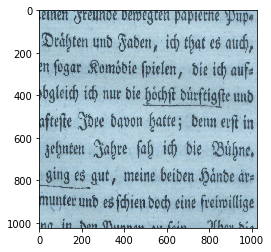

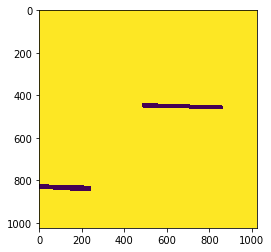

In [5]:
# Apply Normalization when apply_transform = 1
apply_transform = 0
dat = trainset[0]
img = dat[0].numpy().transpose(1,2,0).astype(np.uint8)
gt = dat[1].numpy()
# print(np.unique(img[:,:,:0]))
# print(np.unique(img[:,:,:1]))
# print(np.unique(img[:,:,:2]))
# print(np.unique(img[:,:,:3]))
# print(np.unique(img[:,:,:4]))
plt.imshow(img[:,:,0:3])
plt.show()
plt.imshow(gt.squeeze())
plt.show()

In [6]:
log_dir = "log-mg3/"


def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        torchfcn.models.FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))



configurations = {
    # same configuration as original work
    # https://github.com/shelhamer/fcn.berkeleyvision.org
    1: dict(
        max_iteration=200000,
        lr=1.0e-12,
        momentum=0.99,
        weight_decay=0.0005,
        interval_validate=4000,
    )
}

cfg = configurations[1]
out = log_dir

cuda = torch.cuda.is_available()

torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

resume = ""

model = torchfcn.models.FCN8sAtOnce(n_class=2)
start_epoch = 0
start_iteration = 0
if resume:
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']
else:
    vgg16 = torchfcn.models.VGG16(pretrained=True)
    model.copy_params_from_vgg16(vgg16)

model.conv1_1 = nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))

if cuda:
    model = model.cuda()

optimizer = torch.optim.SGD(
    [
        {'params': get_parameters(model, bias=False)},
        {'params': get_parameters(model, bias=True),
         'lr': cfg['lr'] * 2, 'weight_decay': 0},
    ],
    lr=cfg['lr'],
    momentum=cfg['momentum'],
    weight_decay=cfg['weight_decay'])
if resume:
    optimizer.load_state_dict(checkpoint['optim_state_dict'])

trainer = torchfcn.Trainer(
    cuda=cuda,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=train_loader,
    out=out,
    max_iter=cfg['max_iteration'],
    interval_validate=cfg.get('interval_validate', len(train_loader)),
)
trainer.epoch = start_epoch
trainer.iteration = start_iteration

## Comment out this to train the network from scratch or else see next block to save trained weights.
# trainer.train()

[/home/harsh/data/models/pytorch/vgg16_from_caffe.pth] Checking md5 (aa75b158f4181e7f6230029eb96c1b13)


In [7]:
# # Save a model
# torch.save({
#             'epoch': 5000,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#              'start_iteration' : 0
#             }, 'normalized_resizecrop_5000.pth')

# # Load saved model

checkpoint = torch.load('normalized_resizecrop_5000.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
resume = 'normalized_resizecrop_5000.pth'


In [9]:

def evaluate_model(model, data_loader):
    model.eval()
    i=0
    
    processes = []
    mius = []
    predictions = []
    for index in tqdm(range(len(data_loader.dataset))):
        _, gt_path = data_loader.dataset.samples[index]
        image, _ = data_loader.dataset[index]         
        image = image.numpy()             
#         image[0:3,:,:] = image[0:3,:,:]  
#         i+=1
#         imgg = image[0:3,:,:].transpose(1,2,0).astype(np.uint8)
#         imgg = Image.fromarray(imgg, 'RGB')
        
#         path_1 = os.path.join(os.getcwd(), 'testing_training')
#         img_name = "my"+str(i)+".png"
#         imgg.save(os.path.join(path_1,img_name))        

        
        image.shape = (1, image.shape[0], image.shape[1], image.shape[2])
        prediction = np.zeros((image.shape[2], image.shape[3], 3), dtype=np.uint8)
        div_arr = np.zeros((image.shape[2], image.shape[3]), dtype=np.uint8)        
        offsets_vertical = list(range(0, image.shape[2], 256))
        offsets_horizontal = list(range(0, image.shape[3], 256))
                        

        for v in offsets_vertical:
            for h in offsets_horizontal:
                data = image[:, :, v:v+1024, h:h+1024]   
                
                                                  
                data = torch.from_numpy(data)
                data = data.cuda()
                data = Variable(data, volatile=True)
                score = model(data)                
                lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]                                
                lbl_pred[lbl_pred == 0] = 2
                prediction[v:v+1024, h:h+1024, 2] += lbl_pred.astype(np.uint8).squeeze()
                div_arr[v:v+1024, h:h+1024] += 1
        prediction[:,:,2] = np.round(prediction[:,:,2]/div_arr)
        
        im = Image.fromarray(prediction)
        prediction_path = os.path.join(log_dir, "prediction-private")
        if not os.path.isdir(prediction_path):
            os.makedirs(prediction_path)
        prediction_filename = os.path.join(prediction_path, os.path.basename(gt_path))
        im.save(prediction_filename)
        
        processes.append(subprocess.Popen(["java", "-jar", "LayoutAnalysisEvaluator.jar", "-p", prediction_filename, "-gt", gt_path], stdout=subprocess.PIPE))

    for p in processes:
        miu = float(p.communicate()[0].splitlines()[0].split()[-1])
        mius.append(miu)
    
    print(mius)
    print("average:", np.mean(mius))
    return np.mean(mius)

path = os.path.join(os.getcwd(), '../')
print(os.path.join(path,'Mask_RCNN/samples/shapes/output_test'))

testset = Annotations(img_root=os.path.join(path,'Mask_RCNN/samples/shapes/output_test'),
                      gt_root=os.path.join(path,'Ensembling_Training_with_FCN8/test/gt_png/'),
                      preprocess=None,
                      num_folds=1)


testset.train(False)
# apply_transform = 0
# testset.trainingMean, testset.trainingStd ,testset.gtMean, testset.gtStd = normalize(train_loader, 'train')
# apply_transform = 1
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)


evaluate_model(model, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/harsh/Hackathon_February_2018/../Mask_RCNN/samples/shapes/output_test


/home/harsh/anaconda3/envs/vdlproject/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
100%|██████████| 10/10 [02:30<00:00, 15.07s/it]


[0.8835, 0.8861, 0.93406, 0.82985, 0.5731, 0.87453, 0.86641, 0.78275, 0.92359, 0.90937]
average: 0.846326


0.846326